In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
%cd './drive/MyDrive/CIS530'

Mounted at /content/drive
/content/drive/MyDrive/CIS530


In [ ]:
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D, Flatten, Bidirectional
import tensorflow as tf 
import torch

In [ ]:
df = pd.read_csv('y_pred_new.csv')
rng = np.random.RandomState()

#80%/10%/10% - training, dev, test
# df_train = df.sample(frac=0.8, random_state=rng)
# rest = df.loc[~df.index.isin(df_train.index)]
# df_dev = rest.sample(frac=0.5, random_state=rng)
# df_test = rest.loc[~rest.index.isin(df_dev.index)]

df_train = df.sample(frac=0.9, random_state=rng) #dev set on model
df_test = df.loc[~df.index.isin(df_train.index)]
# df_dev = rest.sample(frac=0.5, random_state=rng)
# df_test = rest.loc[~rest.index.isin(df_dev.index)]

In [ ]:
df.option("truncate", "false")

,Text,Output
0,Most Favored Nation,0
1,Non-Compete,0
2,Exclusivity The Distributor shall not order...,1
3,No-Solicit of Customers Distributor further ag...,0
4,Competitive Restriction Exception,0
...,...,...
16495,Liquidated Damages,0
16496,Warranty Duration,1
16497,Insurance,1
16498,Covenant Not to Sue Except as provided in Sect...,0


In [ ]:
df_train

,Text,Output
1241,Affiliate IP License-Licensee,0
2474,Third Party Beneficiary,0
8753,"Right of First Refusal, Offer or Negotiation (...",0
11535,Non-Transferable License,0
12109,Covenant Not to Sue DISTRIBUTOR acknowledges P...,0
...,...,...
4159,"Non-Compete During the term of this Agreement,...",0
6827,Warranty Duration,0
7346,Affiliate IP License-Licensee,0
3844,Joint IP Ownership,0


In [ ]:
#df_dev

In [ ]:
df_test

,Text,Output
0,Most Favored Nation,0
26,Uncapped Liability,1
27,Cap on Liability,1
32,Third Party Beneficiary,0
38,No-Solicit of Employees,0
...,...,...
16430,Warranty Duration,0
16431,Insurance,0
16460,Uncapped Liability Neither party shall be liab...,0
16473,Non-Disparagement,0


In [ ]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [ ]:
X_train = df_train['Text'].apply(lambda p: clean_text(p))
X_test = df_test['Text'].apply(lambda p: clean_text(p))

max phrase len: 495


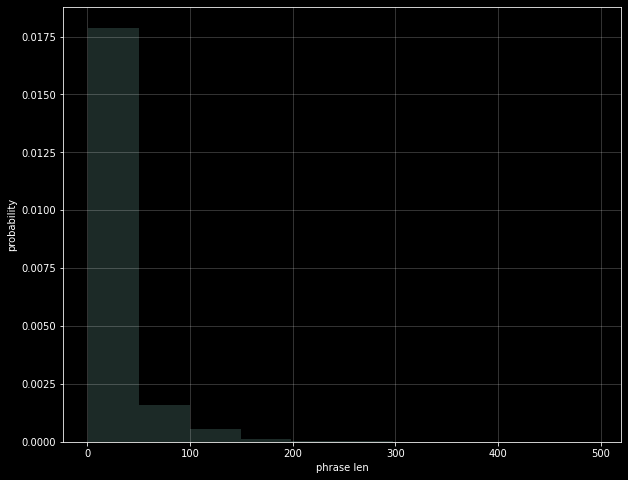

In [ ]:
# Let’s look at the individual length of each phrase in the corpus.
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [ ]:
y_train = df_train['Output']
y_test = df_test['Output']

In [ ]:
X_train.shape

(14850,)

In [ ]:
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
# y_train = to_categorical(y_train)

tokenizer.fit_on_texts(X_test)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_phrase_len)
# y_test = to_categorical(y_test)

y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
batch_size = 512
epochs = 3

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14850, 495)
(14850, 1)
(1650, 495)
(1650, 1)


In [ ]:
model_lstm = Sequential()

# device = torch.device("cuda:0")
# model_lstm.to(device)

model_lstm.add(Embedding(input_dim = max_words, output_dim = 256, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.5))
#model_lstm.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10)))
model_lstm.add(Bidirectional(LSTM(20,dropout=0.3))) 
# model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
# model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3)) #.3
model_lstm.add(Dense(5, activation = 'sigmoid')) #softmax sigmoid
model_lstm.add(Flatten()) 
model_lstm.compile(
    loss=tf.keras.losses.binary_crossentropy, # THIS MIGHT NEED CHANGING categorical_crossentropy, sparse_categorical_crossentropy
    optimizer='Adagrad', #Adam
    metrics=['accuracy']
)

In [ ]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 3,
    batch_size = 512
)

Epoch 1/3
27/27 [==============================] - 13s 330ms/step - loss: 0.6962 - accuracy: 0.3831 - val_loss: 0.6919 - val_accuracy: 0.6572
Epoch 2/3
27/27 [==============================] - 8s 296ms/step - loss: 0.6892 - accuracy: 0.3872 - val_loss: 0.6858 - val_accuracy: 0.6593
Epoch 3/3
27/27 [==============================] - 8s 295ms/step - loss: 0.6836 - accuracy: 0.3853 - val_loss: 0.6805 - val_accuracy: 0.6620


In [ ]:
model_lstm.save('lstm_model.h5')

In [ ]:
from keras.models import load_model
# load model from single file
model = load_model('lstm_model.h5')
# make predictions
yhat = model.predict(X_train, verbose=0)
print(yhat)

[[0.50496626 0.47220662 0.4771032  0.49613342 0.48784626]
 [0.50485694 0.4750873  0.47758496 0.49281025 0.48852333]
 [0.5069669  0.47857532 0.47745785 0.50030816 0.4893857 ]
 ...
 [0.50545037 0.47374734 0.46889785 0.50306135 0.4921635 ]
 [0.5033182  0.47860208 0.47719744 0.5005101  0.48912323]
 [0.50496626 0.47220662 0.4771032  0.49613342 0.48784626]]


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))
# print(y_pred.shape)
# print(y_test.shape)

26/26 [==============================] - 1s 44ms/step
              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83      1276
         1.0       0.00      0.00      0.00       374
         3.0       0.00      0.00      0.00         0

    accuracy                           0.68      1650
   macro avg       0.26      0.29      0.28      1650
weighted avg       0.60      0.68      0.64      1650



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

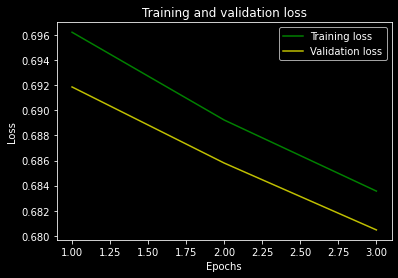

In [ ]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

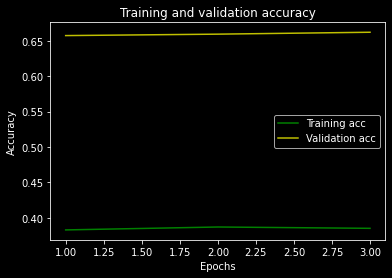

In [ ]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()